# arXiv heatmaps

We study the time-series linear models to make short-term predictions, following the sklearn [time-related feature engineering guide](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html).

First, we load the data from `data/arxiv-totals.parquet`.

In [1]:
import pandas as pd

df = pd.read_parquet("../data/arxiv-totals.parquet")

Later we will regress on the day of the week and the month: we extract and one-hot encode it.

In [2]:
from calendar import day_name

df.reset_index(inplace=True)
df["weekday"] = df["date"].apply(lambda date: day_name[date.weekday()])
df["month"] = df["date"].apply(lambda date: date.month)

one_hot_weekday = (
    pd.get_dummies(df.weekday, dtype=int).drop("Friday", axis=1).iloc[:, [0, 2, 3, 1]]
)
one_hot_month = pd.get_dummies(df.month, dtype=int).drop(12, axis=1)
df = df.join(one_hot_weekday).join(one_hot_month)

df.set_index("date", inplace=True)
df.columns = df.columns.astype(str)

Because the arXiv was still picking up, we have decided to ignore all dates before Jan 1, 2001.  We are also taking our training sample to end on Fri Mar 14, 2025 (included), and our testing sample to start from Mon Mar 17, 2025.

In [3]:
df_train = df[
    (df.index >= pd.Timestamp(2001, 1, 1)) & (df.index <= pd.Timestamp(2025, 3, 14))
]
df_test = df[df.index >= pd.Timestamp(2025, 3, 17)]

To get a sense of how these look like, we plot the submissions from the `math` category.

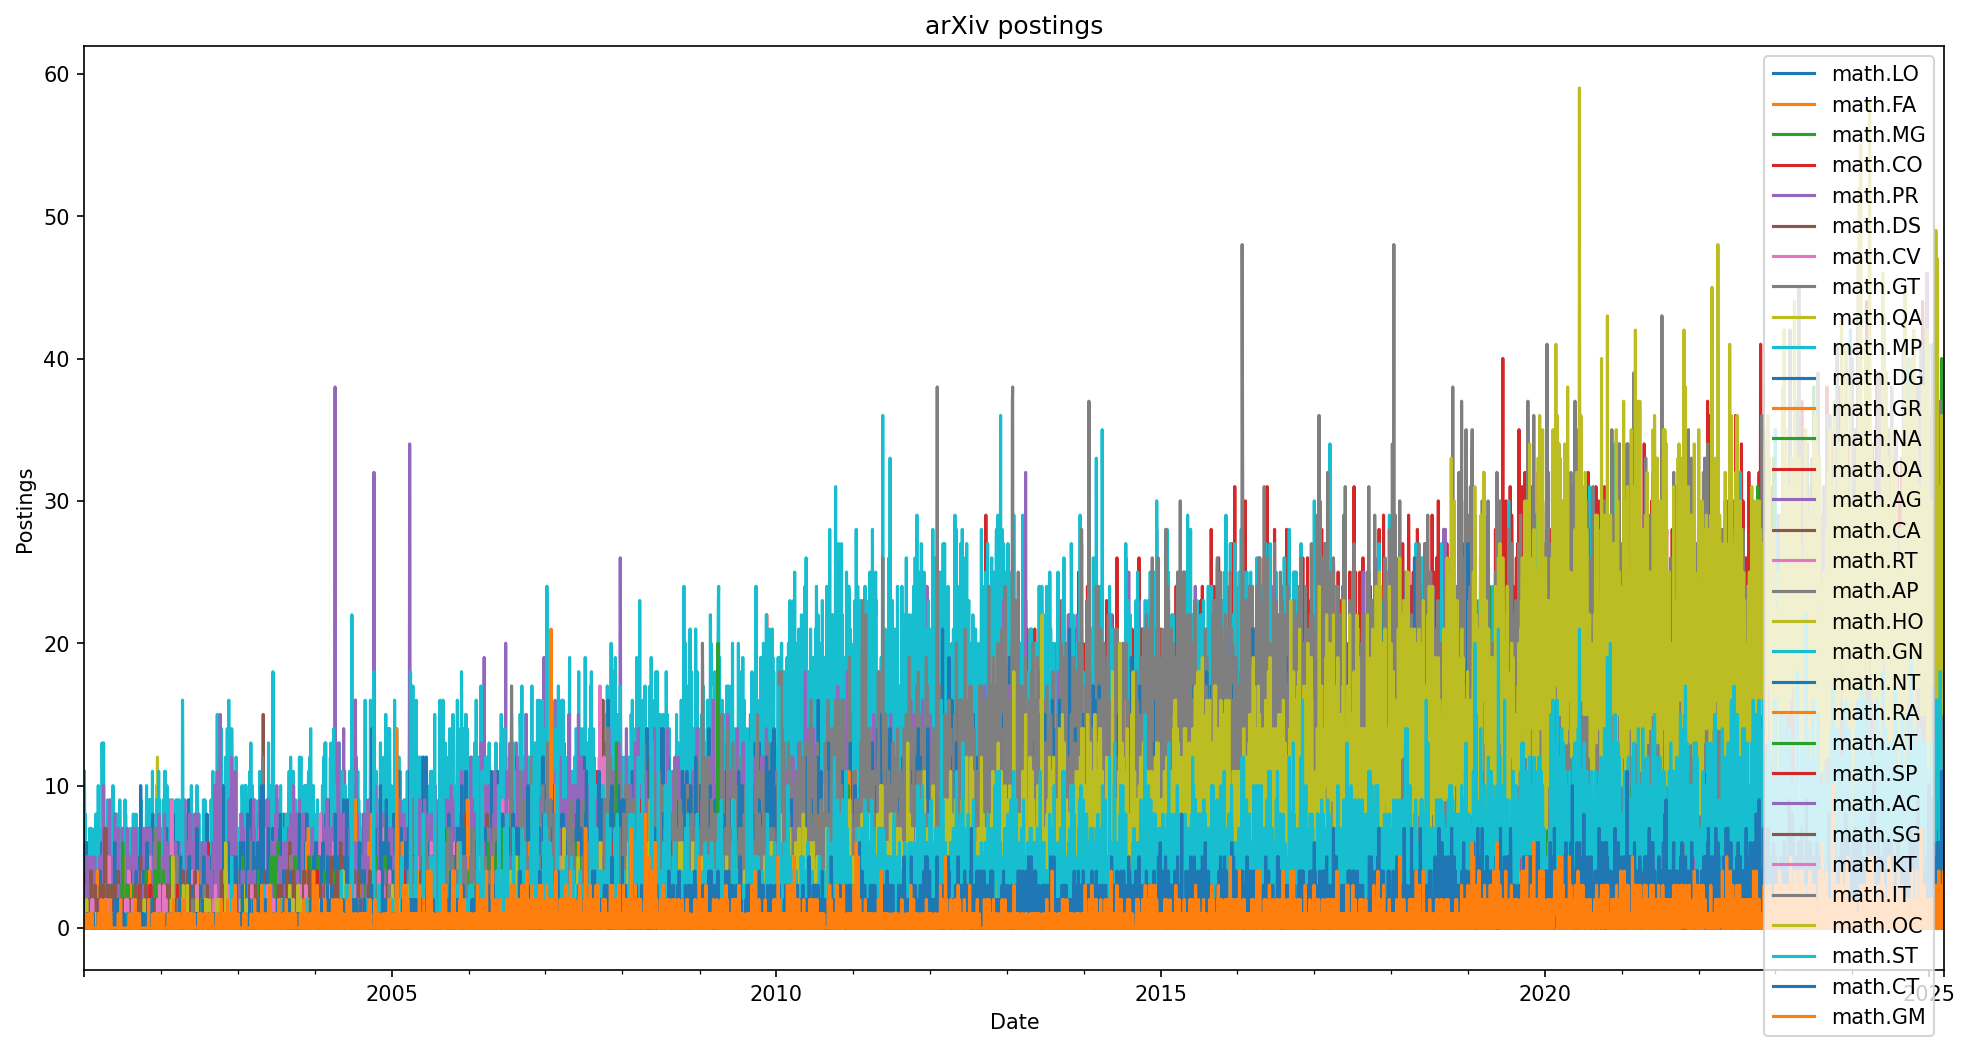

In [4]:
import matplotlib.pyplot as plt

# set plot size
plt.figure(figsize=(16, 8), dpi=150)

# adding the plots
for label, content in df_train.items():
    if label.startswith("math."):  # type: ignore
        content.plot(label=label)

# adding title to the plot
plt.title("arXiv postings")

# adding labels
plt.xlabel("Date")
plt.ylabel("Postings")

# adding legend to the curve
plt.legend()

We also plot `hep-ph` by itself.

Text(0, 0.5, 'Postings')

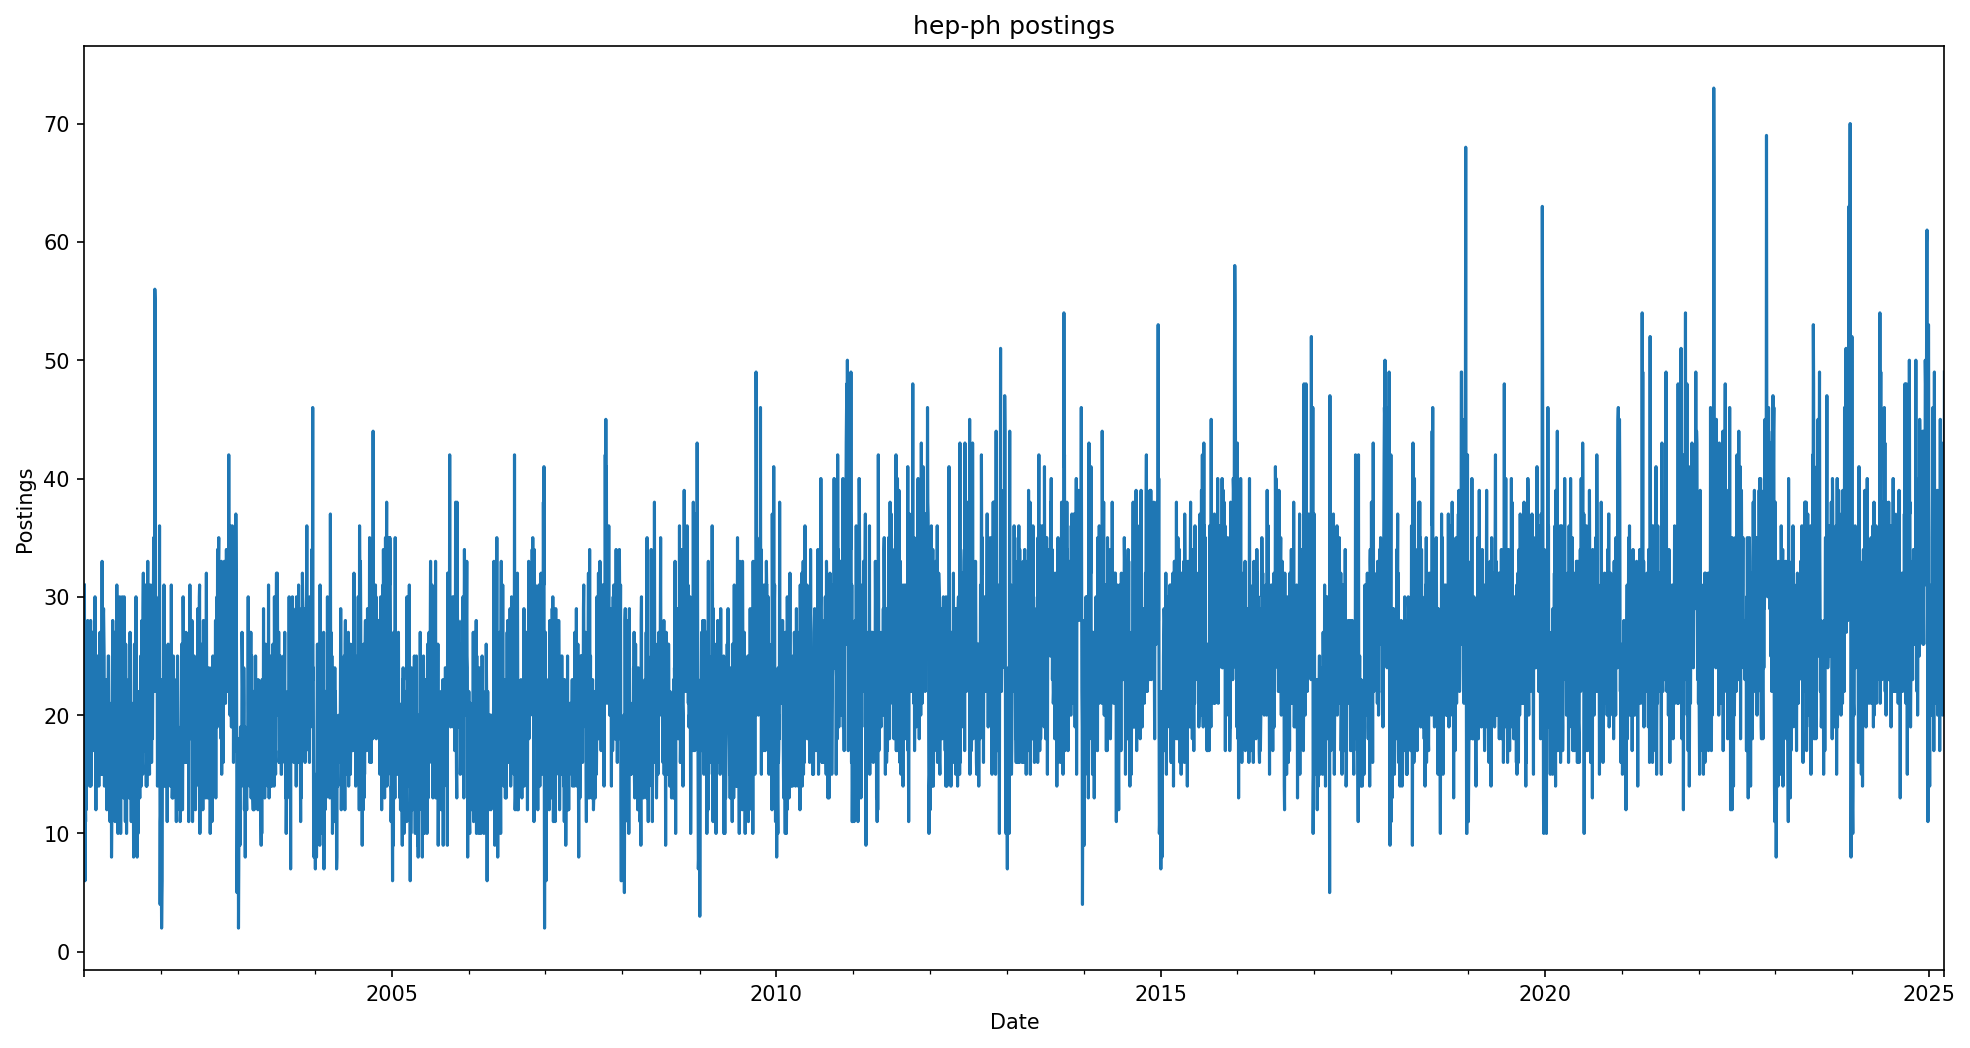

In [5]:
plt.figure(figsize=(16, 8), dpi=150)

df_train["hep-ph"].plot()

plt.title("hep-ph postings")
plt.xlabel("Date")
plt.ylabel("Postings")

We now prepare a 5-fold validation.  We take a gap of 5 business days between train and validation splits, and we take a test size of 15 business days (our forecasting horizon is 5 business days).

In [6]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5, test_size=15, max_train_size=150)

splits = list(ts_cv.split(df_train))

## Models comparison

The models we are going to compare are the following:
- `dummy`: predict the mean of the given window (150 days)
- `t_reg`: linearly regress in time only
- `day_reg`: linearly regress in the days of the week (as categorical feature)
- `mday_reg`: linearly regress in the days of the week and the month (as categorical features)
- `tday_reg`: linearly regress in time and day of the week
- `gbrt`: [gradient boosting](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#gradient-boosting) with categorical features `weekday` and `month`
- `prophet`: [Facebook Prophet](http://facebook.github.io/prophet/)

All the models above are trained on 150 days windows.  We also compare them to the FB Prophet model trained on the entire training time series (`prophet_full`).

In [7]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

from prophet import Prophet

import numpy as np

import json

dummy = DummyRegressor(strategy="mean")
t_reg = LinearRegression()
day_reg = LinearRegression()
mday_reg = LinearRegression()
tday_reg = LinearRegression()
gbrt = HistGradientBoostingRegressor(categorical_features=["weekday", "month"])

dummy_rmses = np.zeros(5)
t_rmses = np.zeros(5)
day_rmses = np.zeros(5)
mday_rmses = np.zeros(5)
tday_rmses = np.zeros(5)
gbrt_rmses = np.zeros(5)
prophet_rmses = np.zeros(5)

with open("../data/arxiv-categories.json", "r") as f:
    arxiv_categories_descriptions = json.load(f)

categories = sorted(
    [cat["tag"] for cat in arxiv_categories_descriptions]
    # We exclude ["q-bio", "cond-mat", "astro-ph"] because they disappeared before our sample starting date.
)
results_dict = {}

for category in categories:
    for i, (train_index, test_index) in enumerate(splits):
        # prepare train data
        df_tt = df_train.iloc[train_index, :]
        df_tt.reset_index(inplace=True)
        df_tt.reset_index(
            inplace=True
        )  # reset index twice to get a column of indexes to use as feature

        # prepare validation data
        df_holdout = df_train.iloc[test_index, :]
        df_holdout.reset_index(inplace=True)
        df_holdout.reset_index(inplace=True)

        # dummy model
        dummy.fit(df_tt[["index"]], df_tt[category])
        dummy_preds = dummy.predict(df_holdout[["index"]])
        dummy_rmses[i] = root_mean_squared_error(df_holdout[category], dummy_preds)

        # t-linear model
        t_reg.fit(df_tt[["index"]], df_tt[category])
        t_preds = t_reg.predict(df_holdout[["index"]])
        t_rmses[i] = root_mean_squared_error(df_holdout[category], t_preds)

        # day-linear model
        day_reg.fit(
            df_tt[["Monday", "Tuesday", "Wednesday", "Thursday"]], df_tt[category]
        )
        day_preds = day_reg.predict(
            df_holdout[["Monday", "Tuesday", "Wednesday", "Thursday"]]
        )
        day_rmses[i] = root_mean_squared_error(df_holdout[category], day_preds)

        # day-linear model
        mday_reg.fit(
            df_tt[
                [
                    "1",
                    "2",
                    "3",
                    "4",
                    "5",
                    "6",
                    "7",
                    "8",
                    "9",
                    "10",
                    "11",
                    "Monday",
                    "Tuesday",
                    "Wednesday",
                    "Thursday",
                ]
            ],
            df_tt[category],
        )
        mday_preds = mday_reg.predict(
            df_holdout[
                [
                    "1",
                    "2",
                    "3",
                    "4",
                    "5",
                    "6",
                    "7",
                    "8",
                    "9",
                    "10",
                    "11",
                    "Monday",
                    "Tuesday",
                    "Wednesday",
                    "Thursday",
                ]
            ]
        )
        mday_rmses[i] = root_mean_squared_error(df_holdout[category], mday_preds)

        # tday-linear model
        tday_reg.fit(
            df_tt[["index", "Monday", "Tuesday", "Wednesday", "Thursday"]],
            df_tt[category],
        )
        tday_preds = tday_reg.predict(
            df_holdout[["index", "Monday", "Tuesday", "Wednesday", "Thursday"]]
        )
        tday_rmses[i] = root_mean_squared_error(df_holdout[category], tday_preds)

        # gradient boosting
        gbrt.fit(df_tt[["weekday", "month"]], df_tt[category])
        gbrt_preds = gbrt.predict(df_holdout[["weekday", "month"]])
        gbrt_rmses[i] = root_mean_squared_error(df_holdout[category], gbrt_preds)

        # prophet
        prophet = Prophet()
        prophet_tt = df_tt[["date", category]].rename(
            columns={"date": "ds", category: "y"}
        )
        prophet_holdout = df_holdout[["date", category]].rename(
            columns={"date": "ds", category: "y"}
        )
        prophet.fit(prophet_tt)
        prophet_preds = prophet.predict(prophet_holdout[["ds"]])["yhat"]
        prophet_rmses[i] = root_mean_squared_error(df_holdout[category], prophet_preds)
        del prophet

    # Different categories have widely different posting rates. To account for
    # that, we rescale the rmses by the max of the category in the training set
    results_dict[category] = (
        np.array(
            [
                dummy_rmses.mean(),
                t_rmses.mean(),
                day_rmses.mean(),
                mday_rmses.mean(),
                tday_rmses.mean(),
                gbrt_preds.mean(),
                prophet_preds.mean(),
                0,
            ]
        )
        / df_train[category].mean()
    )

11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] done processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] done processing
11:03:41 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] done processing
11:03:42 - cmdstanpy - INFO - Chain [1] start processing
11:03:42 - cmdstanpy - INFO - Chain [1] done processing
11:03:42 - cmdstanpy - INFO - Chain [1] start processing
11:03:42 - cmdstanpy - INFO - Chain [1] done processing
11:03:42 - cmdstanpy - INFO - Chain [1] start processing
11:03:42 - cmdstanpy - INFO - Chain [1] done processing
11:03:42 - cmdstanpy - INFO - Chain [1] start processing
11:03:42 - cmdstanpy - INFO - Chain [1] done processing
11:03:42 - cmdstanpy - INFO - Chain [1] start processing
11:03:42 - cmdstanpy - INFO - Chain [1] done processing
11:03:42 - cmdstanpy - INFO - Chain [1] start processing
11:03:42 - cmdstanpy - INFO - Chain [1]

We also run the Facebook Prophet with the full dataset (`prophet_full` model).

In [10]:
ts_cv = TimeSeriesSplit(n_splits=5, test_size=15)

splits = list(ts_cv.split(df_train))

prophet_full_rmses = np.zeros(5)

for category in categories:
    for i, (train_index, test_index) in enumerate(splits):
        # prepare train data
        df_tt = df_train.iloc[train_index, :]
        df_tt.reset_index(inplace=True)
        df_tt.reset_index(
            inplace=True
        )  # reset index twice to get a column of indexes to use as feature

        # prepare validation data
        df_holdout = df_train.iloc[test_index, :]
        df_holdout.reset_index(inplace=True)
        df_holdout.reset_index(inplace=True)

        # prophet
        prophet = Prophet()
        prophet_tt = df_tt[["date", category]].rename(
            columns={"date": "ds", category: "y"}
        )
        prophet_holdout = df_holdout[["date", category]].rename(
            columns={"date": "ds", category: "y"}
        )
        prophet.fit(prophet_tt)
        prophet_preds = prophet.predict(prophet_holdout[["ds"]])["yhat"]
        prophet_full_rmses[i] = root_mean_squared_error(
            df_holdout[category], prophet_preds
        )
        del prophet

    results_dict[category][7] = prophet_full_rmses.mean() / df_train[category].mean()

11:06:59 - cmdstanpy - INFO - Chain [1] start processing
11:07:01 - cmdstanpy - INFO - Chain [1] done processing
11:07:02 - cmdstanpy - INFO - Chain [1] start processing
11:07:04 - cmdstanpy - INFO - Chain [1] done processing
11:07:04 - cmdstanpy - INFO - Chain [1] start processing
11:07:07 - cmdstanpy - INFO - Chain [1] done processing
11:07:08 - cmdstanpy - INFO - Chain [1] start processing
11:07:10 - cmdstanpy - INFO - Chain [1] done processing
11:07:10 - cmdstanpy - INFO - Chain [1] start processing
11:07:12 - cmdstanpy - INFO - Chain [1] done processing
11:07:13 - cmdstanpy - INFO - Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] done processing
11:07:14 - cmdstanpy - INFO - Chain [1] start processing
11:07:16 - cmdstanpy - INFO - Chain [1] done processing
11:07:16 - cmdstanpy - INFO - Chain [1] start processing
11:07:18 - cmdstanpy - INFO - Chain [1] done processing
11:07:18 - cmdstanpy - INFO - Chain [1] start processing
11:07:19 - cmdstanpy - INFO - Chain [1]

In [11]:
results = (
    pd.DataFrame(results_dict)
    .join(
        pd.DataFrame(
            {
                "model": [
                    "dummy",
                    "t_reg",
                    "day_reg",
                    "mday_reg",
                    "tday_reg",
                    "gbrt",
                    "prophet",
                    "prophet_full",
                ]
            }
        )
    )
    .set_index("model")
    .transpose()
)

In [12]:
results

model,dummy,t_reg,day_reg,mday_reg,tday_reg,gbrt,prophet,prophet_full
astro-ph.CO,0.510593,0.511111,0.463992,0.580969,0.465267,1.663033,1.483159,0.432457
astro-ph.EP,0.857071,0.878727,0.837521,0.855076,0.858652,1.903437,1.768274,0.783602
astro-ph.GA,0.779733,0.763716,0.750331,0.870479,0.734992,2.302193,2.225845,0.711223
astro-ph.HE,0.730675,0.728761,0.688845,0.793961,0.686632,2.140697,2.149568,0.652805
astro-ph.IM,0.978891,1.035259,0.929418,0.944577,0.982128,2.360880,2.223218,0.881011
...,...,...,...,...,...,...,...,...
stat.CO,1.350181,1.343354,1.318394,1.432783,1.307019,2.903535,2.868624,1.298259
stat.ME,1.266954,1.276913,0.989934,1.075921,1.008210,3.234106,3.345036,1.109691
stat.ML,1.041047,1.102858,0.774462,0.837341,0.857019,2.274697,2.615044,1.397176
stat.OT,3.075093,3.054447,3.084462,3.169144,3.067074,3.447680,2.899026,3.082256


In [13]:
results.to_csv("short-term-linear-scaled-results.csv")

All models are faring pretty poorly, with a marginal improvement with regression on weekdays, which has the lowest average root mean squared error for approximately 24.5% of the categories.  FB Prophet trained on the entire dataset has the second-lowest mean RMSE over all categories, and is the best model for approximately 34.2% of the categories.

In [14]:
results.mean()

model
dummy           1.475197
t_reg           1.511546
day_reg         1.378326
mday_reg        1.417188
tday_reg        1.417373
gbrt            2.570310
prophet         2.529926
prophet_full    1.409959
dtype: float64

In [19]:
day_is_best = []
margin = []
for index, content in results.iterrows():
    if content.min() == content["day_reg"]:
        day_is_best.append(index)
        margin.append(content["dummy"] - content["day_reg"])

print(
    "Regression on weekdays is the best model for",
    len(day_is_best) / len(categories) * 100,
    "% of the categories.",
)
print()
print("The categories are the following:")
for i in range(len(day_is_best)):
    print("    -", day_is_best[i])
    print("        dummy_rmse - day_rmse =", margin[i])

print()
print("max improvement over dummy =", np.array(margin).max())
print("mean improvement over dummy =", np.array(margin).mean())

Regression on weekdays is the best model for 24.516129032258064 % of the categories.

The categories are the following:
    - cond-mat.mes-hall
        dummy_rmse - day_rmse = 0.09703511450491664
    - cond-mat.mtrl-sci
        dummy_rmse - day_rmse = 0.1291139549035366
    - cs.AR
        dummy_rmse - day_rmse = 0.48170304176166434
    - cs.CE
        dummy_rmse - day_rmse = 0.3740843130494311
    - cs.CR
        dummy_rmse - day_rmse = 0.37688882195092055
    - cs.CY
        dummy_rmse - day_rmse = 0.37711401112835974
    - cs.DB
        dummy_rmse - day_rmse = 0.1730894424378604
    - cs.DC
        dummy_rmse - day_rmse = 0.3057093002916822
    - cs.ET
        dummy_rmse - day_rmse = 0.13395620936453456
    - cs.LG
        dummy_rmse - day_rmse = 0.36052161693813867
    - cs.NE
        dummy_rmse - day_rmse = 0.25498481367382997
    - cs.NI
        dummy_rmse - day_rmse = 0.2504300119076138
    - cs.PF
        dummy_rmse - day_rmse = 0.008506973192232703
    - cs.SE
        dummy_rm

In [20]:
proph_full_is_best = []
margin = []
for index, content in results.iterrows():
    if content.min() == content["prophet_full"]:
        proph_full_is_best.append(index)
        margin.append(content["dummy"] - content["prophet_full"])

print(
    "FB Prophet trained on the entire dataset is the best model for",
    len(proph_full_is_best) / len(categories) * 100,
    "% of the categories.",
)
print()
print("The categories are the following:")
for i in range(len(proph_full_is_best)):
    print("    -", proph_full_is_best[i])
    print("        dummy_rmse - proph_full_rmse =", margin[i])

print()
print("max improvement over dummy =", np.array(margin).max())
print("mean improvement over dummy =", np.array(margin).mean())

FB Prophet trained on the entire dataset is the best model for 34.193548387096776 % of the categories.

The categories are the following:
    - astro-ph.CO
        dummy_rmse - proph_full_rmse = 0.07813617558673597
    - astro-ph.EP
        dummy_rmse - proph_full_rmse = 0.07346960806931668
    - astro-ph.GA
        dummy_rmse - proph_full_rmse = 0.06850953133105853
    - astro-ph.HE
        dummy_rmse - proph_full_rmse = 0.0778697860730545
    - astro-ph.IM
        dummy_rmse - proph_full_rmse = 0.09787935746427567
    - astro-ph.SR
        dummy_rmse - proph_full_rmse = 0.05428636697295841
    - cond-mat.dis-nn
        dummy_rmse - proph_full_rmse = 0.047069771498364776
    - cond-mat.other
        dummy_rmse - proph_full_rmse = 0.04040678701055911
    - cond-mat.quant-gas
        dummy_rmse - proph_full_rmse = 0.05344438348688374
    - cond-mat.soft
        dummy_rmse - proph_full_rmse = 0.04047691691342897
    - cond-mat.stat-mech
        dummy_rmse - proph_full_rmse = 0.0371653195

In [23]:
from prophet.plot import plot_plotly, plot_components_plotly

prophet = Prophet()
prophet_tt = df_train.reset_index()[["date", "hep-th"]].rename(
    columns={"date": "ds", "hep-th": "y"}
)
prophet.fit(prophet_tt)
prophet_preds = prophet.predict(prophet_tt[["ds"]])
plot_plotly(prophet, prophet_preds)

11:41:58 - cmdstanpy - INFO - Chain [1] start processing
11:41:58 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
plot_components_plotly(prophet, prophet_preds)